# Amplitude Encoding Variational Classifier

In [1]:
from visualizer import *
import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform=transforms.Compose([
            transforms.Resize(size=18),
            transforms.CenterCrop(size=16),
            transforms.ToTensor()
        ])

In [3]:
train = datasets.ImageFolder(root='./dataset/dataset_train', transform=transform)
test = datasets.ImageFolder(root='./dataset/dataset_test', transform=transform)
rng = np.random.default_rng(seed=123401234)
num_classes = 4

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

train_set_img = torch.squeeze(train_set_img[:,0,:,:])
test_set_img = torch.squeeze(test_set_img[:,0,:,:])


# permute the arrays so we can visualize different classes with first 10 imgs
rand_idx_train = rng.permutation(len(train_set_img))
X_train = train_set_img[rand_idx_train]
Y_train = train_set_labels[rand_idx_train]

rand_idx_test = rng.permutation(len(test_set_img))
X_test = test_set_img[rand_idx_test]
Y_test = test_set_labels[rand_idx_test]


In [4]:
"""
train = datasets.MNIST('./dataset', train=True, download=True,
                       transform=transform)
test = datasets.MNIST('./dataset', train=False,
                       transform=transform)

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

X_train = train_set_img
X_test = test_set_img
Y_train = train_set_labels
Y_test = test_set_labels
"""

"\ntrain = datasets.MNIST('./dataset', train=True, download=True,\n                       transform=transform)\ntest = datasets.MNIST('./dataset', train=False,\n                       transform=transform)\n\ntrain_loader = DataLoader(train, batch_size=len(train))\ntest_loader = DataLoader(test, batch_size=len(test))\n\ntrain_set_img, train_set_labels = next(iter(train_loader))\ntest_set_img, test_set_labels = next(iter(test_loader))\n\nX_train = train_set_img\nX_test = test_set_img\nY_train = train_set_labels\nY_test = test_set_labels\n"

Input shapes: X_train_input: torch.Size([1000, 256]), X_test_input: torch.Size([200, 256]),Y_train_input: torch.Size([1000]), Y_test_input: torch.Size([200])
number of samples with label 0 in train set: 250
number of samples with label 1 in train set: 250
number of samples with label 2 in train set: 250
number of samples with label 3 in train set: 250
number of samples with label 0 in test set: 50
number of samples with label 1 in test set: 50
number of samples with label 2 in test set: 50
number of samples with label 3 in test set: 50
first 10 img of train set:


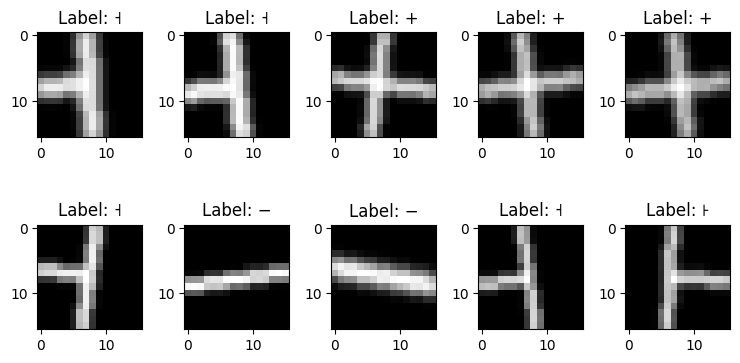

first 10 img of test set:


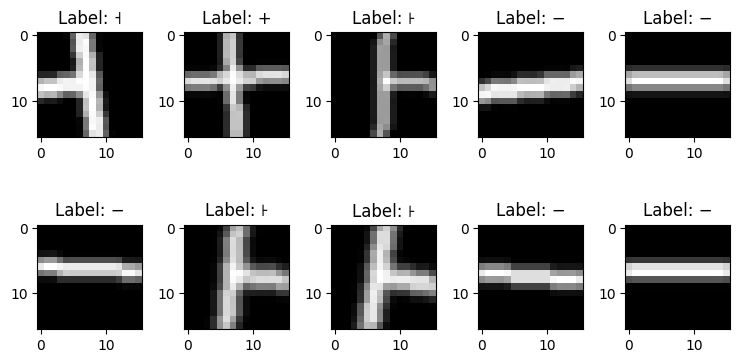

In [5]:
### Visualize some img

classes = [0,1,2,3]
num_classes = len(classes)

def count_occurrences(x,y, set):
    for label in range(len(classes)):
        occurrences = x[y == label].shape[0]
        print(f"number of samples with label {label} in {set} set: {occurrences}")

padding = 0
X_train_input = X_train
Y_train_input = Y_train
X_test_input = X_test
Y_test_input = Y_test

X_train_orig = np.copy(X_train_input.detach().numpy())
X_test_orig = np.copy(X_test_input.detach().numpy())

X_train_input = torch.reshape(X_train_input,(X_train_input.shape[0], -1))
X_test_input = torch.reshape(X_test_input,(X_test_input.shape[0], -1))
    
if padding > 0:
    print("WHY ARE U USING PADDING :(")

print(f"Input shapes: X_train_input: {X_train_input.shape}, X_test_input: {X_test_input.shape},"
            +f"Y_train_input: {Y_train_input.shape}, Y_test_input: {Y_test_input.shape}") 

count_occurrences(X_train_input,Y_train_input, "train")
count_occurrences(X_test_input,Y_test_input, "test")

print('first 10 img of train set:')
show_images(X_train_orig, Y_train_input)

print('first 10 img of test set:')
show_images(X_test_orig, Y_test_input)

# The model

In [6]:
#####################################
NUM_QUBITS = 8
NUM_LAYERS = 32             
INPUT_DIM = 256
#####################################

NUM_CLASSES = num_classes


class QVC(torch.nn.Module):
    def __init__(self, input_dim=INPUT_DIM, output_dim=NUM_CLASSES, num_qubits=NUM_QUBITS, 
                 num_layers=NUM_LAYERS):
        super().__init__()
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        # change device for higher performance!
        self.device = qml.device("default.qubit", wires=self.num_qubits)

        @qml.qnode(self.device)
        def circuit(inputs, weights):
            qml.QubitStateVector(state=inputs, wires=range(self.num_qubits))
            qml.StronglyEntanglingLayers(weights=weights, wires=range(self.num_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]
            
        self.weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=self.num_layers, n_wires=self.num_qubits)
        param_shapes = {"weights" : self.weights_shape}
        init_vals = {"weights" : 0.01 * torch.rand(self.weights_shape)}
        
        self.qcircuit = qml.qnn.TorchLayer(qnode=circuit, weight_shapes=param_shapes, init_method=init_vals)
        #drawer= qml.draw(circuit, show_all_wires=True, expansion_strategy="device")
        #dummy_weights = torch.zeros(self.weights_shape)
        #dummy_inputs = torch.nn.functional.normalize(torch.ones(10,256))
        #print(drawer(dummy_inputs[0],dummy_weights))

    def forward(self, x):
        #print(x.shape)
        x = torch.nn.functional.normalize(x, dim=0)
        return self.qcircuit(x)

In [7]:
#x = torch.ones(10)
#print(torch.nn.functional.normalize(x, dim=0))

In [9]:
#####################################
learning_rate = 0.001
#####################################

feats_train = X_train_input
feats_test = X_test_input
labels_train = Y_train_input
labels_test = Y_test_input
num_train = feats_train.shape[0]


model = QVC()
#model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)
for name, param in model.named_parameters():
    print(name, param.size())
    print(f"requires_grad: {param.requires_grad}")

print(f"feats_train shape: {feats_train.shape}")
print(f"feats_test shape: {feats_test.shape}")
print(f"labels_train shape: {labels_train.shape}")
print(f"labels_test shape: {labels_test.shape}")


def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

QVC(
  (qcircuit): <Quantum Torch Layer: func=circuit>
)
qcircuit.weights torch.Size([32, 8, 3])
requires_grad: True
feats_train shape: torch.Size([1000, 256])
feats_test shape: torch.Size([200, 256])
labels_train shape: torch.Size([1000])
labels_test shape: torch.Size([200])


In [12]:
# training loop and optimizer init

########################
PRETRAINED = True
########################

if PRETRAINED:
    model.load_state_dict(torch.load(f'./model_checkpoints/QVC-Amp-8-32-0_0-ep20'))
    print(f'Loading state_dict of model for epoch 20 and eval on dataset, pls stand by..')
    epochs = 0
else:
    print(f'Beginning training loop for classes {classes}, {NUM_CLASSES} output qubits, {NUM_LAYERS} layers qvc')
    epochs = 20
    
batch_size = 50
num_batches = num_train//batch_size

def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind

def print_acc(epoch, save_checkpoints=False):
    with torch.no_grad():
        if not PRETRAINED and save_checkpoints:
            torch.save(model.state_dict(), f"./model_checkpoints/QVC-Amp-new-8-32-0_0-ep{epoch}")
        predictions_train = [model(f) for f in feats_train[:100]]
        predictions_test = [model(f) for f in feats_test[:100]]
        cost_approx_train = criterion(torch.stack(predictions_train), labels_train[:100])
        cost_approx_test = criterion(torch.stack(predictions_test), labels_test[:100])        
        acc_approx_train = accuracy(labels_train[:100], predictions_train)
        acc_approx_test = accuracy(labels_test[:100], predictions_test)
        
        print("Epoch {:5d} | Approx Cost (train): {:0.7f} | Approx Cost (val): {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f}"
        "".format(epoch, cost_approx_train, cost_approx_test, acc_approx_train, acc_approx_test))
    return predictions_train, predictions_test

for ep in range(epochs):
    batch_ind = gen_batches(num_train, num_batches)
    _, _ = print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]
        
        outputs = [model(f) for f in feats_train_batch]
        loss = criterion(torch.stack(outputs),labels_train_batch)
        loss.backward()
        optimizer.step()

pred_train_final, pred_test_final = print_acc(epochs)      

Loading state_dict of model for epoch 20 and eval on dataset, pls stand by..
Epoch     0 | Approx Cost (train): 0.9936860 | Approx Cost (val): 1.0183240 | Acc train: 0.9900000 | Acc val: 1.0000000


In [13]:
#### ADVERSARIAL ATTACKS ####

def FGSM(loss, eps, feats, labels, weights):
    delta = torch.zeros_like(feats, requires_grad=True)
    loss = criterion(model(feats + delta), labels)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10, randomize=False, positive=False):
    if randomize:
        delta = torch.rand_like(feats, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]
        loss = criterion(torch.stack(outputs),labels)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        if positive:
            delta.data = torch.where((delta+feats)<0,-feats,delta)
        delta.grad.zero_()
    return delta.detach()

In [14]:
perturbed_X_train = PGD(model, feats=feats_train[:100], labels=labels_train[:100], epsilon=0.1, alpha=0.01, 
                  num_iter=10, randomize=False, positive=False)

pred_check = [model(f) for f in feats_train[:100]]
print(f'Benign accuracy: {accuracy(labels_train[:100], pred_check)}')
pred_adv = [model(f) for f in perturbed_X_train[:100]+feats_train[:100]]
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_X_orig = torch.reshape(perturbed_X_train, (100,16,16)).detach().numpy() 
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=torch.stack(pred_adv[10:]).detach().numpy())

KeyboardInterrupt: 

In [ ]:
# here we can also check transferability by loading perturbations from other models

"""
path = './perturbations/perturbations-AmpEnc-no_reg-ep20-PGD0_1-100_samples.npy'
perturbed_X_orig = np.load(path)
perturbed_X_train = torch.reshape(torch.from_numpy(perturbed_X_orig).float(), (100,256))

pred_check = [model(f) for f in feats_train[:100]]
print(f'Benign accuracy: {accuracy(labels_train[:100], pred_check)}')

pred_adv = [model(f) for f in perturbed_X_train[:100]+feats_train[:100]]
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=pred_adv.detach().numpy()[10:])
"""

In [ ]:
pred_check = [model(f) for f in feats_train[:50]]
predictions_adv = [model(f) for f in perturbed_X_train[:100]+feats_train[:100]]
print(f'Sanity check: benign accuracy on train set (first 50 images): {accuracy(labels_train[:50], pred_check)}')
print(f'Adversarial accuracy on train set (first 100 images): {accuracy(labels_train[:100], predictions_adv[:100])}')


In [ ]:
perturbed_X_orig = torch.reshape(perturbed_X_train, (perturbed_X_train.shape[0],16,16))
np.save(file=f"./own_data_pert/perturbations_256_AmpEnc_no-reg_epoch50_PGD_0-2_0-01_100_samples_trainset_20_steps", 
        arr=perturbed_X_orig.numpy())

In [ ]:
#perturbed_X_orig = np.load('./own_data_pert/perturbations_256_AmpEnc_no-reg_epoch20_PGD_0-1_0-01_100_samples_trainset_10_steps.npy')

In [ ]:
check_model(load_epoch, pred_train_final, eps=0.1, alpha=0.01, steps=10, X=feats_train, Y=labels_train, download=False, 
            positive=False, heatmap=True, perturbations=perturbed_X_orig, num=100)

In [ ]:
check_model(20, pred_train_final, 0.1, 0.01, 20, False, False, False)

In [ ]:
check_model(epoch='3-9', pred_check = predictions_train, eps=0.1, alpha= 0.02, steps=10, download=True, positive=True, heatmap=True)

In [ ]:
check_model(epoch='3-9', pred_check = predictions_train, eps=0.8, alpha= 0.06, steps=20, download=True, positive=True, heatmap=True)


In [ ]:
check_model(epoch='3-9', pred_check = predictions_train, eps=1.0, alpha= 0.08, steps=20, download=True, positive=True, heatmap=True)


In [ ]:

np.save(file="weights_6QB_196inp-Reup-11Lay-400samples-FMNIST-0-1.npy", arr=weights)
#from google.colab import files
#files.download('weights_6QB_196inp-Reup-11Lay-400samples-FMNIST-0-1.npy')

In [ ]:
noise = np.random.normal(loc=0.0, scale=0.06, size=(14,14))
show_single(X_train_filtered[0]+noise)


In [ ]:
# find out which features are important; set top m and lowest m pixels to white/black ,respectively

#num_samples_for_feat_selec = 10
num_iter = 50
arr_inp_feats = np.zeros((400,11,6,3))
X_feat_selec = feats_train
Y_feat_selec = labels_train
grad = np.zeros(arr_inp_feats.shape)
#show_images(X_train_filtered[500:], Y_feat_selec)
assert np.all(X_feat_selec == feats_train) 

for j in range(num_iter):
    #noise = 0.05 * np.random.random((num_samples_for_feat_selec,11,6,3))
    noise = np.random.normal(loc=0.0, scale=0.06, size=(11,6,3)) 
    #grad = qml.grad(cost, argnum=2)(weights, bias, X_feat_selec+noise, Y_feat_selec)
    
    # try this out:
    for k in range(grad.shape[0]):
        grad[k] = qml.grad(variational_classifier, argnum=2)(weights, bias, X_feat_selec[k]+noise[k])
    #print(grad.shape)
    arr_inp_feats += grad
    
assert np.all(X_feat_selec == feats_train)

arr_inp_feats /= num_iter


In [ ]:
arr_inp_feats_re = np.reshape(arr_inp_feats, (arr_inp_feats.shape[0],198))[:,:-2]
sorted_ind = np.argsort(arr_inp_feats_re)
#print(sorted_ind.shape)
#print(arr_inp_feats_re[0])
#print(sorted_ind[0])

highest_ind = sorted_ind[:,-10:]
lowest_ind = sorted_ind[:,:10]
#print(highest_ind.shape)
#print(lowest_ind.shape)
#print(highest_ind[0])

# blank max feats
feats_blank_high = np.zeros((10,196))
feats_blank_low = np.zeros((10,196))

# set values in orig images
feats_re = np.copy(X_feat_selec)
feats_re = np.reshape(feats_re, (feats_re.shape[0], -1))[:,:-2]
feats_re = feats_re[:10]

for i in range(10):
    if Y_feat_selec[i] == 1:
        feats_blank_high[i,highest_ind[i]] = 1
        feats_blank_low[i,lowest_ind[i]] = 1
        feats_re[i,highest_ind[i]] = 0
        feats_re[i,lowest_ind[i]] = 1
    else:
        feats_blank_high[i,lowest_ind[i]] = 1
        feats_blank_low[i,highest_ind[i]] = 1
        feats_re[i,highest_ind[i]] = 1
        feats_re[i,lowest_ind[i]] = 0
    
feats_undo = np.reshape(feats_re,(feats_re.shape[0], 14,14))
feats_blank_high = np.reshape(feats_blank_high,(10, 14,14))
feats_blank_low = np.reshape(feats_blank_low,(10, 14,14))

arr_inp_feats_re = np.reshape(arr_inp_feats_re, (arr_inp_feats_re.shape[0],14,14))

#assert np.all(X_feat_selec == feats_train[:10])    #??????
#pred_train = [variational_classifier(weights, bias, f) for f in feats_train[:10]]



In [ ]:
print(np.min(arr_inp_feats_re))

In [ ]:
show_images_pred(X_train_filtered[:10], Y_train_filtered[:10] ,predictions_train)
show_images_heatmaps(arr_inp_feats_re,Y_feat_selec, predictions_train, None, False, None, None, only_img=True, switched=True, eps=0.18)
show_images(feats_blank_high,Y_feat_selec)
show_images(feats_blank_low,Y_feat_selec)

feats_re_model = np.pad(feats_re,((0,0),(0,2)))
feats_re_model = np.reshape(feats_re_model, (10,) + weights_shape)
pred_changed = [variational_classifier(weights, bias, f) for f in feats_re_model[:10]]

show_images_pred(feats_undo, Y_feat_selec, pred_changed)

In [ ]:
def show_important_pixels(orig, pixels):
    f = np.concatenate([pixels[..., None],
                        np.zeros((14, 14, 1)).astype(int),
                        orig[..., None]], axis=-1)
    plt.imshow(f)
    plt.show()
    
def show_images_important_pixels(X, Y, pred, high, low, saved=False, name=None):
    #predic = [np.argmax(p) for p in pred]
    predic = [1 if p > 0.5 else 0 for p in pred]
    num = 10
    images = X[:num]
    labels = Y[:num]
    num_row = 2
    num_col = 5# plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        pixels_high = high[i]
        pixels_low= low[i]
        orig = X[i]
        f = np.concatenate([pixels_low[..., None],
                            pixels_high[..., None],
                            orig[..., None]], axis=-1)
        ax.imshow(f)
        ax.set_title('Label: {}/ {}'.format(labels[i], predic[i]))
    plt.tight_layout()
    if saved:
      plt.savefig(f"{name}.png")
    else:
      plt.show()
    
#show_important_pixels(X_train_filtered[1],feats_blank_low[1])
show_images_important_pixels(X_train_filtered, Y_train_filtered, predictions_train, feats_blank_high, feats_blank_low, saved=False, name=None)
#show_important_pixels(X_train_filtered[8],feats_blank_low[8])

In [ ]:
#pred_train = [variational_classifier(weights, bias, f) for f in feats_train[:num_samples_for_feat_selec]]
#show_images(X_train_filtered, Y_feat_selec)
show_images_pred(np.abs(arr_inp_feats_re),Y_feat_selec, pred_train)

In [ ]:
heatmap_ones = np.sum(arr_inp_feats_re[Y_feat_selec==1],axis=0)/len(arr_inp_feats_re[Y_feat_selec==1])
heatmap_zeros = np.sum(arr_inp_feats_re[Y_feat_selec==0],axis=0)/len(arr_inp_feats_re[Y_feat_selec==1])
show_single_heatmap(heatmap_zeros)
show_single_heatmap(heatmap_ones)

In [ ]:
show_single(np.abs(heatmap_ones+heatmap_zeros))

In [ ]:
show_images(X_train_filtered,Y_train_filtered)
show_images(perturbed_X_orig, labels_train)
show_images(X_train_filtered[:10] + perturbed_X_orig, Y_train_filtered)

In [ ]:
predictions_adv = [variational_classifier(weights, bias, f) for f in perturbed_X]
acc_adv = accuracy(Y_train_filtered, predictions_adv)

#predictions_orig = [variational_classifier(weights, bias, f) for f in feats_train[:]]

#X_train_orig = np.reshape(feats_train, (feats_train.shape[0],108))[:,:100]
#X_train_orig = np.reshape(X_train_orig, (X_train_orig.shape[0],10,10))

#X_train_orig = np.reshape(X_train_input, (X_train_input.shape[0],108))[:,:100]
#X_train_orig = np.reshape(X_train_orig, (X_train_orig.shape[0],10,10))

#show_images_pred(X_train_orig, Y_train_input, predictions_orig)
show_images_pred(perturbed_X_orig+X_train_filtered[:10], Y_train_filtered, predictions_adv)
#show_images_pred(perturbed_X_orig[10:], Y_train_input[10:], predictions_adv[10:])
#show_images_pred(perturbed_X_orig[20:], Y_train_input[20:], predictions_adv[20:])
print(f"Adversarial accuracy: {acc_adv}")